# Transformer

* powerful DL approach based on (self) attention
* very popular (not a scientific category, though): BERT


### new properties

* multi head attention
* layer normalization
* residual connections (add & norm)
* positional encoding

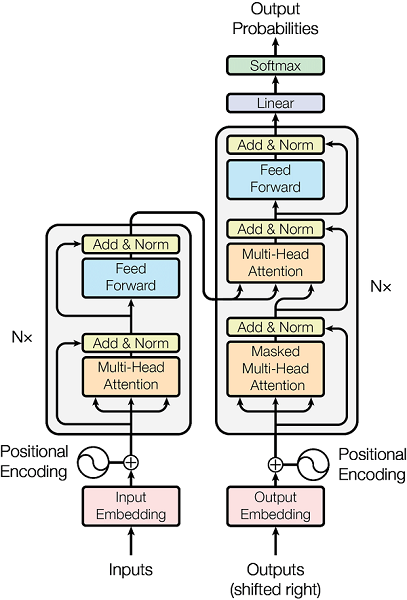

## Self Attention 

**Attention** is a mechanism to find out where to look in the context trying to predict parts of a sequence (a sequence over time like text).


**Self attention** is an attention mechanism relating different positions of a single sequence in order to compute a representation of the same sequence (from Lilian Weng).

* for each element (word), we determine a weighted representation depending on how well the element suits (in) its context
* we do it via word embeddings and a similarity measure
* dot product is a similarity measure

* example: movie recommendation
    * a 1st vector represents features of the movie
    * a 2nd vector represents interests of a user
* dot product is high if overlap is high

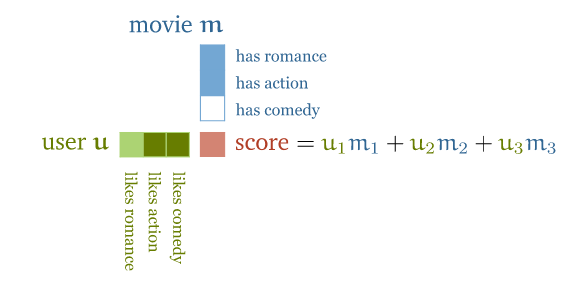

### Rational behind Self Attention

* self attention: how well fits a word in its context (sentence)
* represent a word by its word embedding
* x is the sequence of word embeddings of a sentence
* take the dot product of x with itself
* result: a matrix that records the mutual similarity of all words

In [1]:
import torch
import torch.nn.functional as F

torch.manual_seed(10)
x=torch.rand(1,2,3)
x                     # 2 words, 3 dimensional word embedding

tensor([[[0.4581, 0.4829, 0.3125],
         [0.6150, 0.2139, 0.4118]]])

In [2]:
x.transpose(1,2)

tensor([[[0.4581, 0.6150],
         [0.4829, 0.2139],
         [0.3125, 0.4118]]])

In [3]:
torch.matmul(x,x.transpose(1,2))   

tensor([[[0.5406, 0.5137],
         [0.5137, 0.5936]]])

In [4]:
# same operation with batch matmul

raw_weights=torch.bmm(x,x.transpose(1,2))
raw_weights

tensor([[[0.5406, 0.5137],
         [0.5137, 0.5936]]])

* cell 0,0: similarity of first vector with itself (0.5406)
* cell 0,1: similarity of first vector with second vector (0.5137)
* cell 1,0: similarity of second vector with first vector   (0,1 and 1,0 are symmetric)
* cell 1,1:  similarity of second vector with itself

In [5]:
weights = F.softmax(raw_weights, dim=2)
weights

tensor([[[0.5067, 0.4933],
         [0.4800, 0.5200]]])

* we get a probability distribution per row
* 0,1 and 1,0 are no longer symmetric (since softmax)

In [6]:
x

tensor([[[0.4581, 0.4829, 0.3125],
         [0.6150, 0.2139, 0.4118]]])

0.5355 

0.4933 weights the importance of all values of the second vector from the perspective of the first vector

as an effect: if a vector is very similar to its context then its importance is raised (the values increase)

In [7]:
y = torch.bmm(weights, x)   # or simply torch.matmul(weights, x)
y

tensor([[[0.5355, 0.3502, 0.3615],
         [0.5397, 0.3430, 0.3641]]])

result: contextualized input sequence

**that's the basic idea**


### Learnable Self Attention (query, key, value)

* so far, everything is static - no room for learning
* in order to learn, we need weight matrices

$$\large A(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

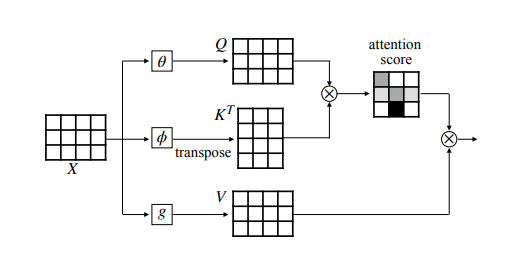


### computations per example $x_i$ ($j$ is index of some other example)


* $\large q_i = W_qx_i, k_i=W_kx_i, v_i=W_vx_i$


* $\large w'_{ij} = \frac{q_ik_j^T}{\sqrt{d_k}}$ ($d_k$ = length of key)


* $\large w_{ij}=softmax(w'_{ij})$


* $\large y_i = \sum_j w_{ij}v_j$



### query, key, value

Every input vector $𝐱_i$ is used in three different ways in the self attention operation:

* It is compared to every other vector to establish the weights for its own output $𝐲_i$
* It is compared to every other vector to establish the weights for the output of the j-th vector $𝐲_j$
* It is used as part of the weighted sum to compute each output vector once the weights have been established

These roles are often called the query, the key and the value.

(see: http://peterbloem.nl/blog/transformers)

In [8]:
torch.manual_seed(10)

fdim=2     # feature dimension
seqdim=3

x=torch.rand(1,seqdim,fdim)
x

tensor([[[0.4581, 0.4829],
         [0.3125, 0.6150],
         [0.2139, 0.4118]]])

In [9]:
torch.manual_seed(0)

Wq = torch.randn(1,fdim,seqdim)
Wq

tensor([[[ 1.5410, -0.2934, -2.1788],
         [ 0.5684, -1.0845, -1.3986]]])

In [10]:
Q=torch.matmul(Wq,x)
Q

tensor([[[ 0.1481, -0.3337],
         [-0.3777, -0.9685]]])

In [11]:
torch.manual_seed(1)

Wk = torch.rand(1,fdim,seqdim)
Wk

tensor([[[0.7576, 0.2793, 0.4031],
         [0.7347, 0.0293, 0.7999]]])

In [12]:
K=torch.matmul(Wk,x)
K

tensor([[[0.5206, 0.7036],
         [0.5168, 0.7022]]])

In [13]:
torch.manual_seed(2)

Wi = torch.rand(1,fdim,seqdim)
Wi

tensor([[[0.6147, 0.3810, 0.6371],
         [0.4745, 0.7136, 0.6190]]])

In [14]:
V = torch.matmul(Wi,x)
V

tensor([[[0.5370, 0.7935],
         [0.5728, 0.9229]]])

In [15]:
dk=len(Wk[0][0])
dk

3

In [16]:
import numpy as np

QK=F.softmax(Q @ K.transpose(1,2)/np.sqrt(dk),dim=2)
QK

tensor([[[0.5000, 0.5000],
         [0.4996, 0.5004]]])

In [17]:
torch.matmul(QK,V)

tensor([[[0.5549, 0.8582],
         [0.5549, 0.8583]]])

### pytorch attention

In [18]:
import torch
from torch import nn
import torch.nn.functional as F

In [19]:
x=torch.rand(1,2,3)
print("input x:\n",x)

class attention(nn.Module):
    def __init__(self,  fdim):
        super().__init__()

        self.tokeys = nn.Linear(fdim,fdim,bias=False)
        self.toqueries = nn.Linear(fdim,fdim,bias=False)
        self.tovalues = nn.Linear(fdim,fdim, bias=False)
                
       # print(list(self.tokeys.parameters()))
    
    def forward(self,x):
        Q=self.toqueries(x)
        K=self.tokeys(x)
        V=self.tovalues(x)
        #print(Q.size(),K.size())
        QK = Q @ K.transpose(1,2)
        QK_softmax = F.softmax(QK, dim=-1)
        
        weighted_values = QK_softmax @ V
        
        return weighted_values
    
selfatt=attention(3)      
print("weighted x:\n",selfatt(x))

input x:
 tensor([[[0.4425, 0.0958, 0.6142],
         [0.0573, 0.5657, 0.5332]]])
weighted x:
 tensor([[[-0.1773, -0.0453, -0.0796],
         [-0.1774, -0.0451, -0.0792]]], grad_fn=<UnsafeViewBackward>)


In [20]:
class transformer(nn.Module):
    
    def __init__(self, k):
        super().__init__()

        self.attention = attention(k)

        self.norm = nn.LayerNorm(k)

        self.ff = nn.Linear(k, 1)
          
    def forward(self, x):
        
        attended = self.attention(x)
        
        x = self.norm(attended + x)  # residual connection from x

        fedforward = self.ff(x)
        
        return fedforward 

In [21]:
trans=transformer(3)
trans(x)   # a prediction for the two examples, now we'd determine some loss etc.

tensor([[[1.0185],
         [0.0264]]], grad_fn=<AddBackward0>)